# DTSA 5511: NLP Disaster Tweets Kaggle Mini-Project

## Description

The following will be an analysis of tweets that come during disasters through a RNN. This is important for crisis centers to know to automatically distinguish between calls-to-action and false alarms.

## Exploratory Data Analysis (EDA)

Import all libraries used.

In [1]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from wordcloud import WordCloud
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.callbacks import LambdaCallback
import squarify

Install or download any libraries needed.

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\staci\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Turn off unneccessary warnings.

In [3]:
# Ignore Warnings
warnings.filterwarnings("ignore")

Read data from CSV files into data frames. 

In [4]:
# Import Files into CSVs
data_train = pd.read_csv('./text/train.csv')
data_test = pd.read_csv('./text/test.csv')

Take a quick look into the data.

In [5]:
data_train.head(5)
data_test.head(5)

print("Memory Size of DataFrame: ", data_train.memory_usage(deep=True).sum())
print("Rows:", len(data_train))
print("Columns:", len(data_train.columns))

Memory Size of DataFrame:  2282658
Rows: 7613
Columns: 5


Since the 'text' column was the only one analyzed, the data frame was converted into a single array of this column.

In [6]:
df = data_test['text']

For more thorough text analysis, stop words were removed during this portion.

In [15]:
# Declare Empty List
df_stop = list()

# Function for Stop Words
sw = set(stopwords.words('english'))

# Loop to Go Through Column and Filter For Stop Words
for c1 in range(len(df)):
    text = df.loc[c1]
    tkn = word_tokenize(text)
    filtered_text = [word for word in tkn if word.lower() not in sw]
    df_stop.append(' '.join(filtered_text))

Now that the stop words have been removed, evalute the word count and plot through a histogram.

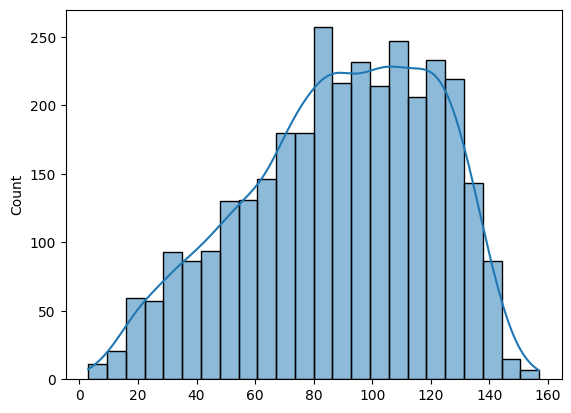

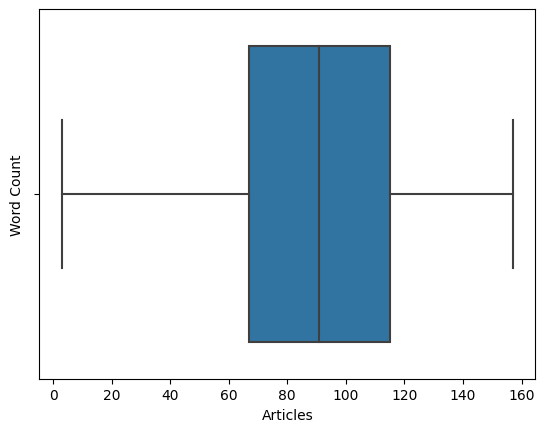

In [16]:
# check the amount of word in each article 
word_count = [len(text) for text in df_stop]

# Create histogram
sns.histplot(word_count, kde=True)
plt.show()

# Create Box Plot
sns.boxplot(word_count)
plt.xlabel('Articles')
plt.ylabel('Word Count')
plt.show()

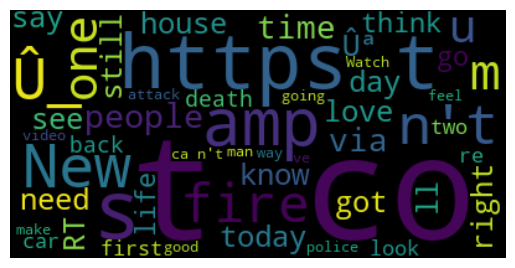

In [21]:
# Concatenate and Split Text
all_text = ' '.join(df_stop)
words = all_text.split()

# Generate Word Cloud
wordcloud = WordCloud(max_words=50)
wordcloud.generate(all_text)

# Display the word cloud using matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

As expected, in the top 50 words there are terms like people, fire, attack, house, and police. However, due to the nature of the text scraping, the term https which stands for Hyper Text Protocol Secure, reveals itself despite being a part of the scraper text and not the twitter text. Also, despite the stop words removing unneccessary parts, there are still several articles, conjunctions, and pronouns. A different library for removal might be consulted next time. Thus, terms that started with "http" were removed before assembling the model.

In [23]:
# Remove "http" text

# New List for Data Frame
df_filt = []

# For Loop
for sent in df_stop:
    words = sent.split()
    filt_word = [word for word in words if not word.startswith("http")]
    filt_sent = ' '.join(filt_word)
    df_filt.append(filt_sent)

Print out the new word cloud to verify the http portion has been removed.

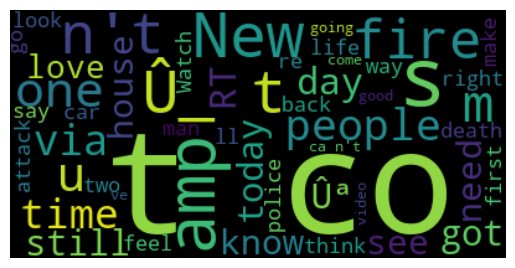

In [24]:
# Concatenate and Split Text
all_text = ' '.join(df_filt)
words = all_text.split()

# Generate Word Cloud
wordcloud = WordCloud(max_words=50)
wordcloud.generate(all_text)

# Display the word cloud using matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Success! The http portion has been removed.

## Results

Next, a RNN was created. Training parameters were declared, the data frame was imported, and vocabulary for integers to characters was created. Note: only the first 50 words were imported due to large run times encountered testing the RNN.

In [33]:
# Declare Training Data Parameters
seq_len = 40
data_X = []
data_y = []

# Load and Preprocess
df_RNN = df_filt[:50]
text = ' '.join(df_RNN).lower()  

# Create Vocab
chars = sorted(list(set(text)))
num_chars = len(chars)

# Map Char to Int and Int to Char
char_to_int = {char: c1 for c1, char in enumerate(chars)}
int_to_char = {c1: char for c1, char in enumerate(chars)}

A word sequence was produced for the text which was converted from characters into integers. These underwent normalization and one-hot encoding for the RNN to have an easier time deciphering. 

In [34]:
# Get Sequence for X and Y
for c1 in range(0, len(text) - seq_len):
    seq_in = text[c1:c1 + seq_len]
    seq_out = text[c1 + seq_len]
    data_X.append([char_to_int[char] for char in seq_in])
    data_y.append(char_to_int[seq_out])

# Normalize and One-hot encode
X = np.reshape(data_X, (len(data_X), seq_len, 1))
X = X / float(num_chars)
y = np.eye(num_chars)[data_y]

Next, the RNN models was built with the standard LSTM input layer, the dense ReLU intermediate one, and a final soft max layer as an output. The categorical cross entropy loss was chosen since the model dealt with text and the optimizer chosen was adam in this case too.

In [35]:
# Build RNN model with Multiple Layers
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, input_shape=(X.shape[1], X.shape[2])),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_chars, activation='softmax')
])

# Compile the Model, loss Selected Based On Single Class and Optimizer Because Text Input
model.compile(loss='categorical_crossentropy', optimizer='adam')

Next, text was generated and compared based on a BLEU and diversity metric. 

In [36]:
# Function for Text Generation
def generate_text(epoch, temp):
    
    # Function to Get Next Character
    def next_char_func(pred, temp):
        pred = np.asarray(pred).astype('float64')
        pred = np.log(pred) / temp
        exp_preds = np.exp(pred)
        pred = exp_preds / np.sum(exp_preds)
        prob = np.random.multinomial(1, pred, 1)
        return np.argmax(prob)

    # Generate Characters
    if epoch % 2 == 0:
        start_index = np.random.randint(0, len(data_X) - seq_len - 1)
        text_gen = text[start_index:start_index + seq_len]
        text_out = text_gen

        # Create Characters
        for c1 in range(40):
            x = np.reshape([char_to_int[char] for char in text_gen], (1, seq_len, 1))
            x = x / float(num_chars)
            pred = model.predict(x, verbose=0)[0]
            next_index = next_char_func(pred, temp)
            next_char = int_to_char[next_index]
            text_out += next_char
            text_gen = text_gen[1:] + next_char
            
        print()
        print(text_out)

        # Get Diversity Metrics Function
        def div_met(text):
            tkns = nltk.word_tokenize(text)
            tkns_cnt = nltk.FreqDist(tkns)
            total_count = len(tkns)
            prob = [count / total_count for count in tkns_cnt.values()]
            entropy = -np.sum([p * np.log2(p) for p in prob])
            diversity_metric = 1 / (entropy + 1e-7)  
            return diversity_metric

        # Calculate BLEU score
        ref = [text_gen.split()]  
        cand = text_out.split()  
        bleu_score = sentence_bleu(ref, cand)
        print("BLEU score:", bleu_score)

        # Calculate diversity metric
        diversity = div_met(' '.join(cand))
        print("Diversity metric:", diversity)

Finally, the model was run with different inputs for batch size. The text was evaluated with varying temperatures to fine-tune for diversity and with different epoch sizes.

In [37]:
# Function to Generate Model Output
for temp in [0.5, 1]:
    
    # Call Function to Generate Text
    print("Temperature Value:", temp)
    text_generation_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: generate_text(epoch, temp))
    model.fit(X, y, epochs=5, batch_size=4, callbacks=[text_generation_callback])
    print()

Temperature Value: 0.5
Epoch 1/5
905/905 [==============================] - ETA: 0s - loss: 3.3892
ictim dies sets ablaze : 16-year-old gir ao  tp  eatn nn    ofe n   n a   s c e 
BLEU score: 0.573057404379869
Diversity metric: 0.24637739063238012
905/905 [==============================] - 63s 66ms/step - loss: 3.3892
Epoch 2/5
905/905 [==============================] - 54s 60ms/step - loss: 3.3191
Epoch 3/5
905/905 [==============================] - ETA: 0s - loss: 3.2962
a currently delays 10 mins due accident   # ao f s iat cal   n   t so s n  a s ?
BLEU score: 0.6395028446903569
Diversity metric: 0.2515458677148573
905/905 [==============================] - 62s 68ms/step - loss: 3.2962
Epoch 4/5
905/905 [==============================] - 56s 62ms/step - loss: 3.2491
Epoch 5/5
905/905 [==============================] - ETA: 0s - loss: 3.1806
ns front field house wer set ablaze day n s rociie krre k s tec x c e/eiee k /na
BLEU score: 0.5653636138834072
Diversity metric: 0.24260490545

## Hyperparameters

The two parameters that were modified were the epoch and the temperature size. The epoch cound didn't have a strong effect on the BLEU score or the diversity metric. When it came to temperature, going from 0.5 to 0.1 resulted in a decrease in BLEU score and the diversity metric. This means that the text looks less human and there is less diversity when it comes to the strings.

## Discussion and Conclusion

#### Lessons Learned

Looking back on this, if the report consulted GitHub directly or ran this dataset remotely through a cloud, more rows could have been processed as well as testing further an increase in the batch size. 

#### Areas for Improvement

After running the output, there was the realization that the model could generate a BLEU and diversity metric without outputting the strings, especially in the case of disaster tweets, that it used to compare. These were left as a memorable part of the report, but is not advised.

#### Future Work

For those that are interested, running the model with less epochs, larger batch sizes, and testing a temperature range that explores the larger territories might produce more interesting results. With adequate amount of computing power, more of the tweets could be examined to refine the model and produce a more clear -- if desired, output.